In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read csv files
path_csv = f"../outputs/"
path_to_save_figures = f"../figures/"

df_close_source_all = pd.read_csv(path_csv + "df_close_source_all_unified_no_ICL_11_2.csv")
df_open_source_all = pd.read_csv(path_csv + "df_open_source_all_unified_no_ICL_11_2.csv")

# concatenate the two dataframes
df_all = pd.concat([df_close_source_all, df_open_source_all])

### Drop bad rows

In [3]:
# get all rows with uncertainty value outside of the 0-10 range
df_all_uncertainty_outside_range = df_all[(df_all["uncertainty"] < 0) | (df_all["uncertainty"] > 10)]

# get all rows with uncertainty values that are nan
df_all_uncertainty_nan = df_all[df_all["uncertainty"].isna()] # ignore for now

# drop all rows with uncertainty value outside of the 0-10 range
df_all = df_all.drop(df_all_uncertainty_outside_range.index)

# drop the "question", "label", "response" columns
df_all = df_all.drop(columns=["question", "label", "response"])

def _modify_model_name(model_name):
    if model_name == "chatgpt":
        return "gpt-3.5-turbo-0613"
    elif model_name == "palm":
        return "chat-bison-001"
    elif model_name == "claude":
        return "claude-2"
    else:
        return model_name
    
df_all["model_name"] = df_all["model_name"].apply(_modify_model_name)

df_all

,model_name,task_name,task_mode,uncertainty,correctness,refusal
0,gpt-3.5-turbo-0613,FalseQA,answerable,8.0,NaN,False
1,gpt-3.5-turbo-0613,FalseQA,answerable,2.0,NaN,False
2,gpt-3.5-turbo-0613,FalseQA,answerable,7.0,NaN,False
3,gpt-3.5-turbo-0613,FalseQA,answerable,8.0,NaN,False
4,gpt-3.5-turbo-0613,FalseQA,answerable,7.0,NaN,False
...,...,...,...,...,...,...
93228,vicuna-13b-v1.5,RefuNQ,unanswerable,8.0,NaN,False
93229,vicuna-13b-v1.5,RefuNQ,unanswerable,3.0,NaN,False
93230,vicuna-13b-v1.5,RefuNQ,unanswerable,8.0,NaN,False
93231,vicuna-13b-v1.5,RefuNQ,unanswerable,6.0,NaN,True


## Refusal and Accuracy Aggregated - for all models

In [4]:
# I would like to get a table describing the following:
# Refusal Rate:
# |  model_name   | Answerable | Unanswerable (both aggregated across 3 datasets) | accuracy

# | GPT-4 | 1% | 98% | 99% |
# | GPT-3.5 | xxx | xxx | xxx |

# get a df that contains all rows with a given model_name
def get_df_model_name(df_all, model_name):
    df_model_name = df_all[df_all["model_name"] == model_name]
    return df_model_name

def get_df_task_name(df_model_name, task_name):
    df_model_task_name = df_model_name[df_model_name["task_name"] == task_name]
    return df_model_task_name

def get_answerable_unanswerable(df_model_name):
    df_answerable = df_model_name[df_model_name["task_mode"] == "answerable"]
    df_unanswerable = df_model_name[df_model_name["task_mode"] == "unanswerable"]
    return df_answerable, df_unanswerable

def get_refusal_and_accuracy(df_model_name):
    # get answerable and unanswerable
    df_answerable, df_unanswerable = get_answerable_unanswerable(df_model_name)
    # get refusal rate
    refusal_rate_answerable = df_answerable["refusal"].mean()
    refusal_rate_unanswerable = df_unanswerable["refusal"].mean()
    # get accuracy
    df_refunq = get_df_task_name(df_answerable, "RefuNQ")
    accuracy_answerable = df_refunq["correctness"].mean()
    
    # get total number of answerable and unanswerable
    total_answerable = len(df_answerable)
    total_unanswerable = len(df_unanswerable)
    
    # get total number of answerable refunq
    total_answerable_refunq = len(df_refunq)

    return refusal_rate_answerable, refusal_rate_unanswerable, accuracy_answerable, total_answerable, total_unanswerable, total_answerable_refunq


all_model_list = [
    "gpt-3.5-turbo-0613", 
    "gpt-4-0613",
    "claude-2",
    "chat-bison-001",
    "Llama-2-7b-chat-hf",
    "Llama-2-7b-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-13b-hf",
    "Llama-2-70b-chat-hf",
    # "Llama-2-70b-hf",
    "vicuna-7b-v1.5",
    "vicuna-13b-v1.5"
]

df_res = pd.DataFrame(columns=["model_name", "refusal_rate_answerable", "refusal_rate_unanswerable", "delta", "accuracy_answerable"])
for model_name in all_model_list:
    df_model_name = get_df_model_name(df_all, model_name)
    refusal_rate_answerable, refusal_rate_unanswerable, accuracy_answerable, total_answerable, total_unanswerable, total_answerable_refunq= get_refusal_and_accuracy(df_model_name)
    delta = refusal_rate_unanswerable - refusal_rate_answerable
    
    # to percentage, keep 3 significant digits 
    refusal_rate_answerable *= 100
    refusal_rate_unanswerable *= 100
    delta *= 100
    accuracy_answerable *= 100
    
    refusal_rate_answerable = round(refusal_rate_answerable, 1)
    refusal_rate_unanswerable = round(refusal_rate_unanswerable, 1)
    delta = round(delta, 1)
    accuracy_answerable = round(accuracy_answerable, 1)
    
    # append them to a df
    df_res = df_res.append({
        "model_name": model_name,
        "refusal_rate_answerable": refusal_rate_answerable,
        "num_answerable": total_answerable,        
        "refusal_rate_unanswerable": refusal_rate_unanswerable,
        "num_unanswerable": total_unanswerable,
        "delta": delta,
        "accuracy_answerable": accuracy_answerable,
        "num_answerable_RefuNQ": total_answerable_refunq
    }, ignore_index=True)

df_res.to_csv("refusal_rate_all_models.csv", index=False)

    
    # print(f"{model_name} & {refusal_rate_answerable:.3f} & {refusal_rate_unanswerable:.3f} & {delta:.3f} & {accuracy_answerable:.3f} \\\\")



/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/1909593501.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res = df_res.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/1909593501.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res = df_res.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/1909593501.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res = df_res.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/1909593501.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_res = df_res.append({
/var/folders/vf/68qlybbd65v4

In [5]:
proprietary_model_list = [
    "gpt-3.5-turbo-0613", 
    "gpt-4-0613",
    "claude-2",
    "chat-bison-001",
]

opensource_model_list = [
    "Llama-2-7b-chat-hf",
    "Llama-2-7b-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-13b-hf",
    "Llama-2-70b-chat-hf",
    # "Llama-2-70b-hf",
    "vicuna-7b-v1.5",
    "vicuna-13b-v1.5"
]

model_list_all = proprietary_model_list + opensource_model_list

task_names = ["RefuNQ", "FalseQA", "NEC"]
task_modes = ["answerable", "unanswerable"]

## Get refusal / correctness stats by table

In [6]:
def generate_table_for_model(model_name, task_name, task_mode, df_all):
    df_model_task_type = df_all[(df_all["model_name"] == model_name) & (df_all["task_name"] == task_name) & (df_all["task_mode"] == task_mode)]
    return df_model_task_type

# model_name = "gpt-3.5-turbo-0613"
# task_name = "RefuNQ"
# task_mode = "answerable"
# df_model_task_type = generate_table_for_model(model_name, task_name, task_mode, df_all)
    

def calculate_correctness_stats(df_model_task_type, column_of_interest):
    # Group by 'uncertainty' and aggregate on 'correctness' to get count and mean
    result = df_model_task_type.groupby('uncertainty')[column_of_interest].agg(['sum', 'mean']).reset_index()
    result.columns = ['uncertainty', 'num_true', 'percentage']
        
    # drop rows with percentage = 0
    result = result[result["percentage"] != 0]
    
    # add a column num_total
    result["num_total"] = (result["num_true"] / result["percentage"]).astype(int)
        
    # reorder columns
    result = result[["uncertainty", "num_true", "num_total", "percentage"]]
    
    return result

for task_name in task_names:
    for task_mode in task_modes:
        for model_name in model_list_all:
            
            if task_mode == "answerable" and task_name == "RefuNQ":
                column_of_interest = "correctness"
            else:
                column_of_interest = "refusal"
            
            df_model_task_type = generate_table_for_model(model_name, task_name, task_mode, df_all)
            result = calculate_correctness_stats(df_model_task_type, column_of_interest)
            # save result to csv
            result.to_csv(f"/Users/genglinliu/Documents/GitHub/LLM-hallucination/AAA/figures/refusal_and_accuracy_tables_no_ICL/{task_name}_{task_mode}_{model_name}.csv", index=False, sep="\t")
            
            print(f"task_name: {task_name}, task_mode: {task_mode}, model_name: {model_name}")
            print(result)
            print()

# NOTE: the total number of questions for each uncertainty value is num_true / percentage

task_name: RefuNQ, task_mode: answerable, model_name: gpt-3.5-turbo-0613
   uncertainty num_true  num_total  percentage
0          2.0        9         21    0.428571
1          3.0        6         10    0.600000
2          5.0       15         51    0.294118
3          7.0      174        450    0.386667
4          8.0      664       1359    0.488595
5          9.0      227        374    0.606952

task_name: RefuNQ, task_mode: answerable, model_name: gpt-4-0613
   uncertainty num_true  num_total  percentage
0          0.0       36         94    0.382979
1          1.0        8         54    0.148148
2          2.0        3         24    0.125000
3          3.0        3         17    0.176471
4          5.0       19         55    0.345455
5          6.0        2          6    0.333333
6          7.0       64        153    0.418301
7          8.0      146        325    0.449231
8          9.0      120        265    0.452830
9         10.0      816       1273    0.641005

task_name: Ref

## Uncertainy Distribution

In [15]:
# get a df that contains all rows with a given model_name
def get_df_model_name(df_all, model_name):
    df_model_name = df_all[df_all["model_name"] == model_name]
    return df_model_name

def get_df_task_name(df_model_name, task_name):
    df_model_task_name = df_model_name[df_model_name["task_name"] == task_name]
    return df_model_task_name

def plot_uncertainty_distribution_for_model_name(df_model_name, model_name):
    # three plots, one for each task_name, plot both modes in the same plot
    # produce one grid plot for all three task_names with grid size 3x1

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    for i, task_name in enumerate(["FalseQA", "NEC", "RefuNQ"]):
        df_chatgpt_task_name_task_mode = df_model_name[(df_model_name["task_name"] == task_name)]
        sns.histplot(data=df_chatgpt_task_name_task_mode, x="uncertainty", bins=10, hue="task_mode", ax=axes[i], edgecolor="gray")        
        axes[i].set_title(f"{model_name} | {task_name}")
        axes[i].set_xlabel("Verbalized Confidence Score")
        axes[i].set_ylabel("count")
        
        # fix x axis range
        # axes[i].set_xlim(0, 10)
        
        # title, axis and label font size larger
        axes[i].title.set_size(22)
        axes[i].xaxis.label.set_size(22)
        axes[i].yaxis.label.set_size(22)
        axes[i].tick_params(axis='both', which='major', labelsize=22)
        # legend font size larger
        
    plt.tight_layout()
    plt.savefig(path_to_save_figures + f"/uncertainty_distribution_for_models_10_31/uncertainty_distribution_for_{model_name}.pdf")


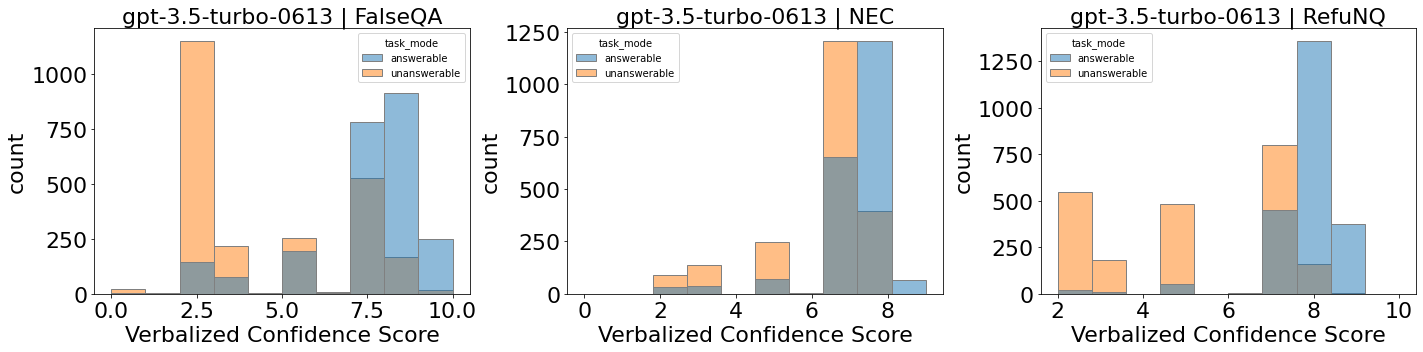

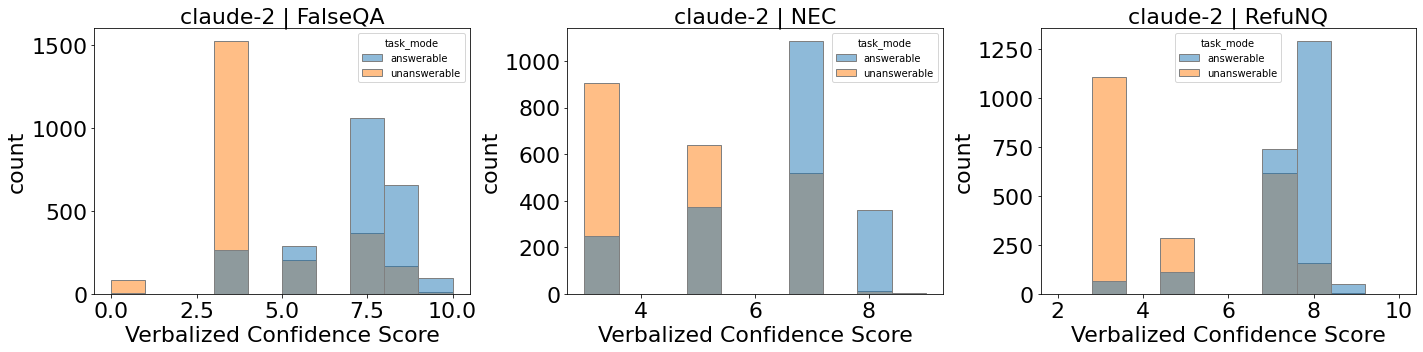

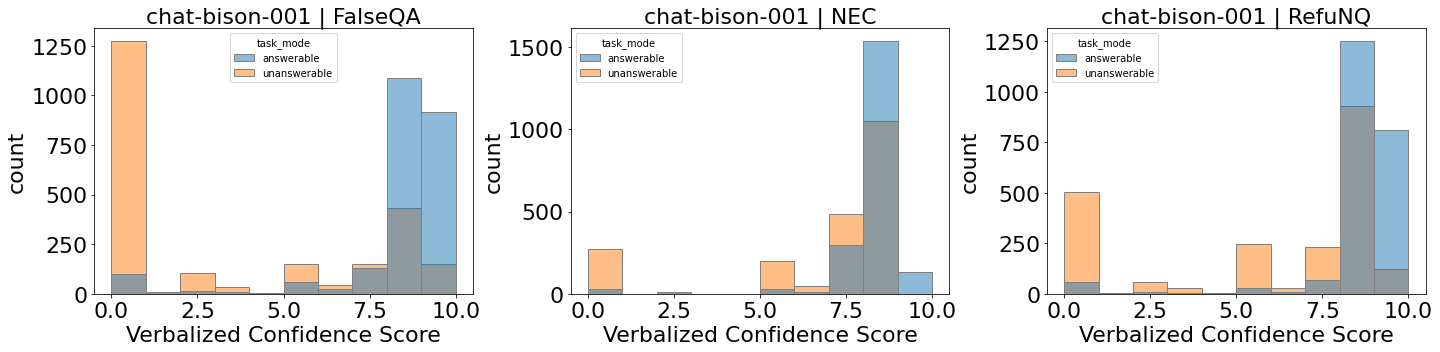

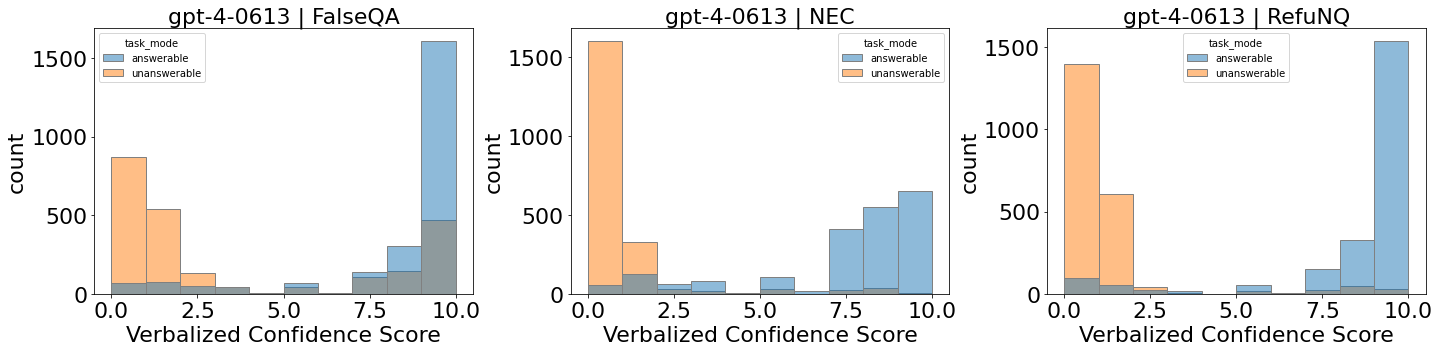

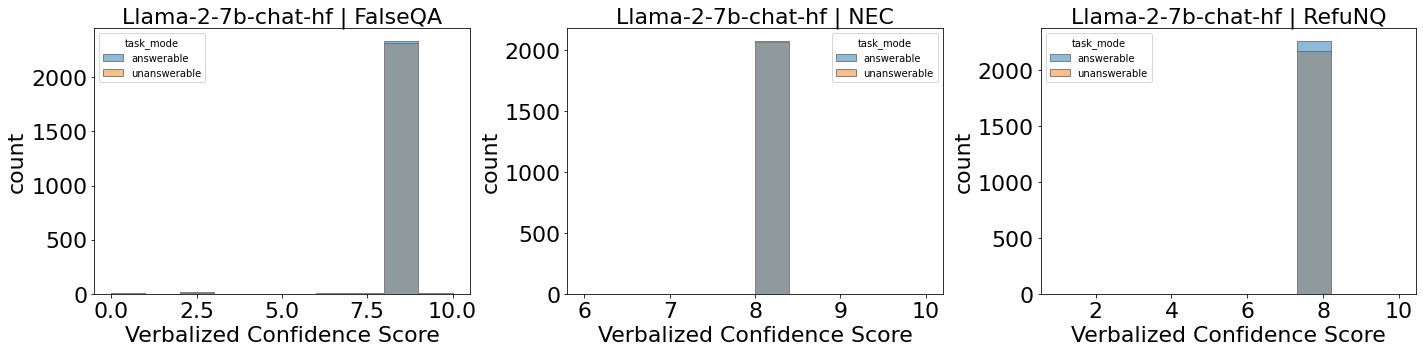

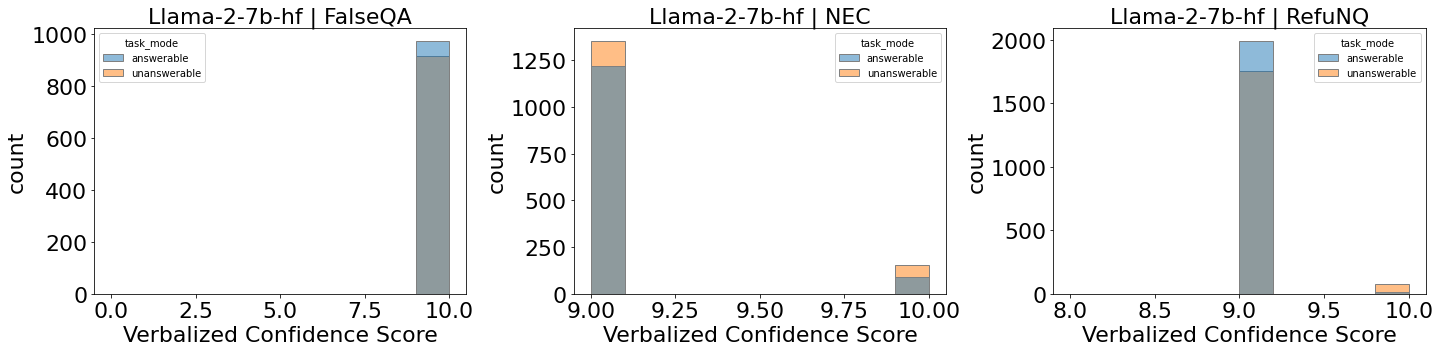

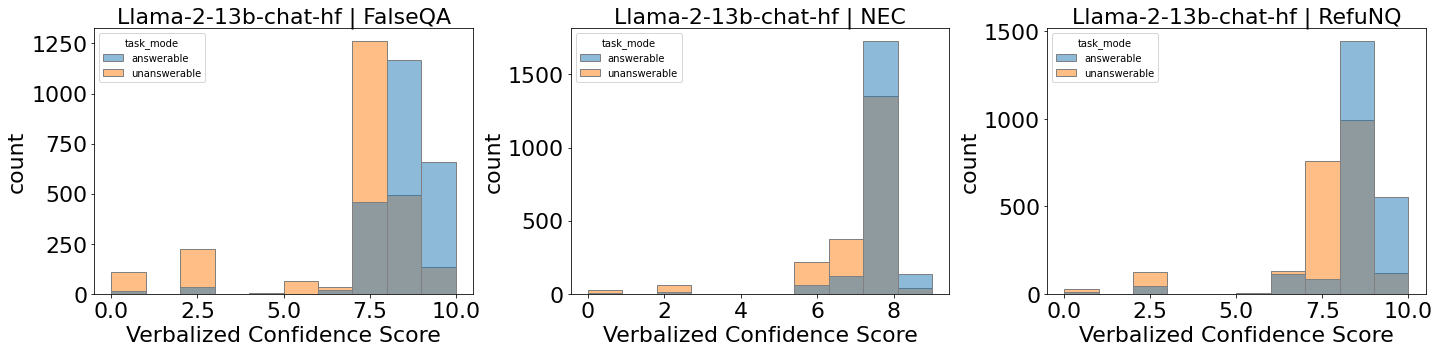

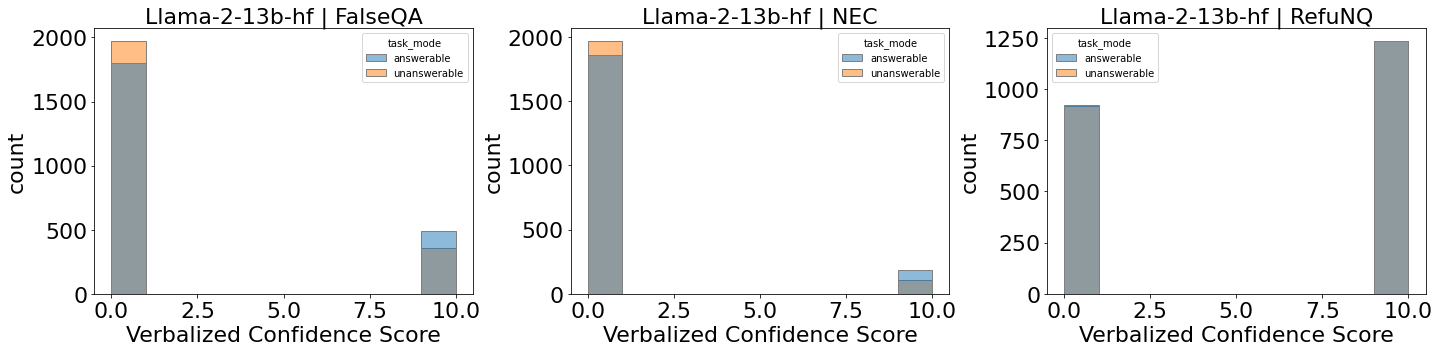

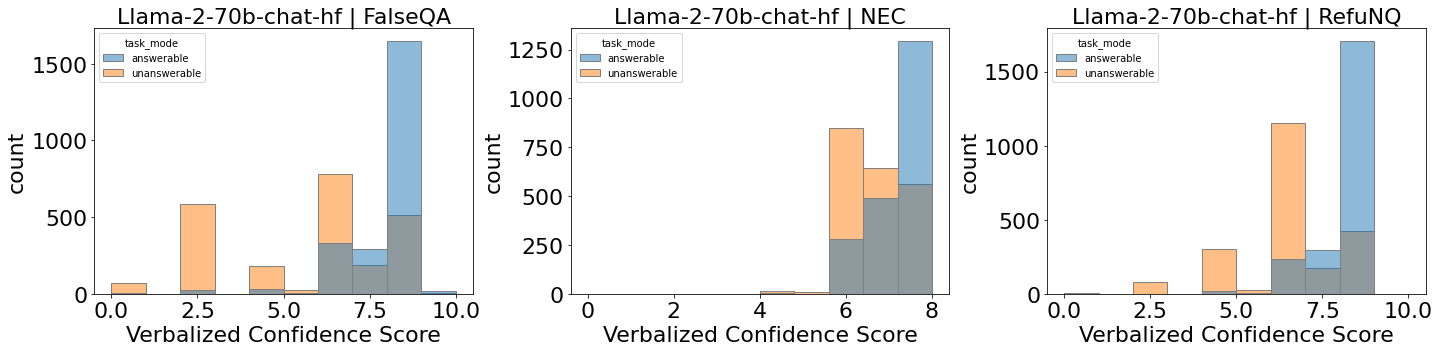

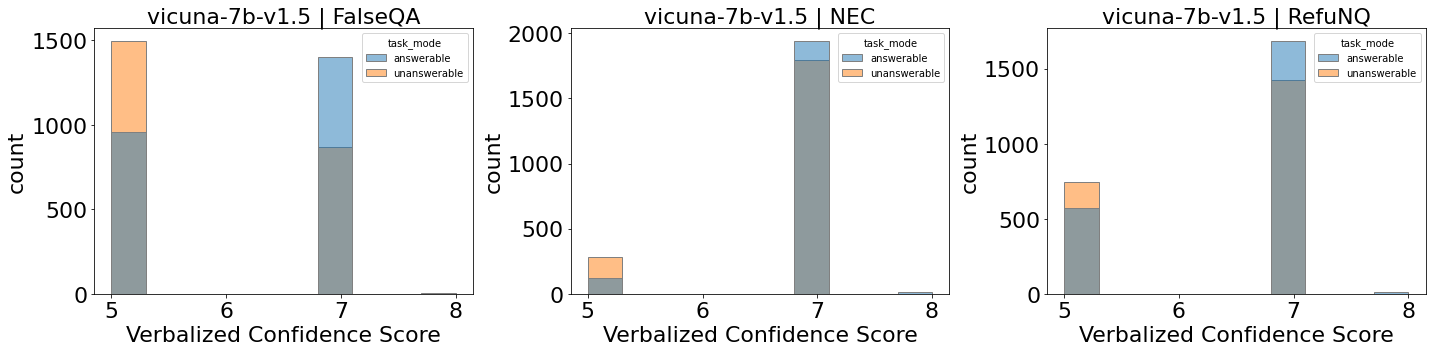

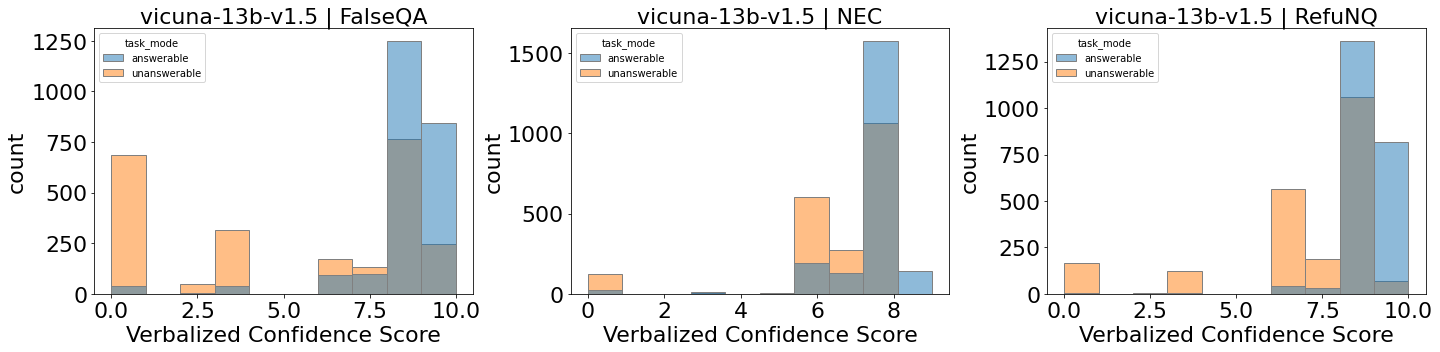

In [16]:
# run uncertainty distribution plot for each model_name

model_list = df_all["model_name"].unique()

for model_name in model_list:
    df_model_name = get_df_model_name(df_all, model_name)
    plot_uncertainty_distribution_for_model_name(df_model_name, model_name)


## Refusal and Accuracy vs. Uncertainty Levels 

FalseQA Llama-2-13b-hf
NEC Llama-2-13b-hf
RefuNQ Llama-2-13b-hf


/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({


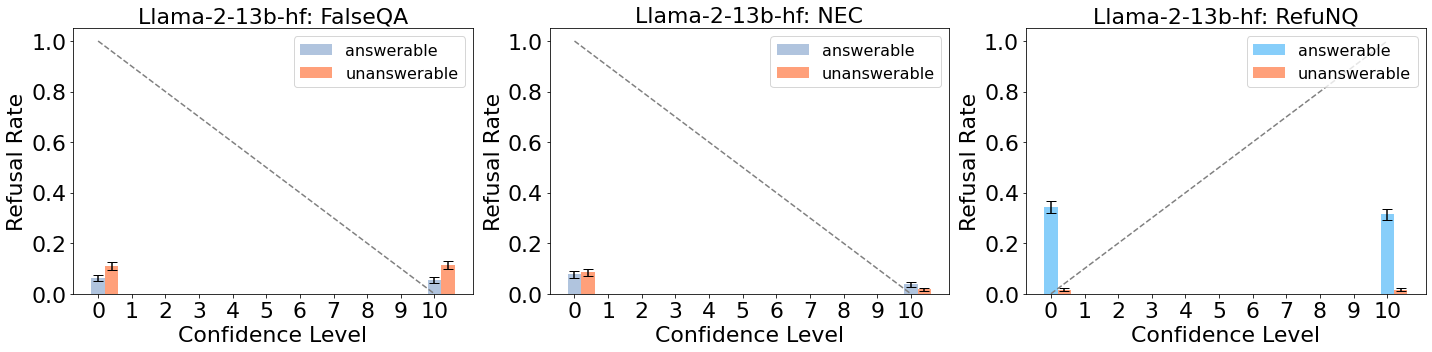

In [11]:
def generate_refusal_and_accuracy_plot_for_model_name(model_name, error_bar_scale=0.05):
    task_names = ["FalseQA", "NEC", "RefuNQ"]
    df_model_name = get_df_model_name(df_all, model_name)

    # Adjusting the for loop to plot in a grid
    fig, axes = plt.subplots(nrows=1, ncols=len(task_names), figsize=(20, 5))
    
    df_corr_all = pd.DataFrame(columns=["model_name", "task_name", "corr_answerable", "corr_unanswerable"])

    for idx, task_name in enumerate(task_names):
        ax = axes[idx]
        df_model_task_type = get_df_task_name(df_model_name, task_name)

        # get the refusal rate for each value of uncertainty
        rate_answerable = []
        rate_unanswerable = []
        num_answerable = []
        num_unanswerable = []
        std_answerable = []
        std_unanswerable = []
        for uncertainty in range(0, 11):
            df_uncertainty_answerable = df_model_task_type[(df_model_task_type["uncertainty"] == uncertainty) & (df_model_task_type["task_mode"] == "answerable")]
            if task_name == "RefuNQ":
                rate_answerable.append(round(df_uncertainty_answerable["correctness"].mean(), 3))
                std_answerable.append(round(df_uncertainty_answerable["correctness"].std(), 3))
                # num_answerable should append the total number of rows for that uncertainty level
                num_answerable.append(len(df_uncertainty_answerable))
                    
            else:
                rate_answerable.append(round(df_uncertainty_answerable["refusal"].mean(),3))
                std_answerable.append(round(df_uncertainty_answerable["refusal"].std(), 3))
                num_answerable.append(len(df_uncertainty_answerable))

            df_uncertainty_unanswerable = df_model_task_type[(df_model_task_type["uncertainty"] == uncertainty) & (df_model_task_type["task_mode"] == "unanswerable")]
            rate_unanswerable.append(round(df_uncertainty_unanswerable["refusal"].mean(), 3))
            std_unanswerable.append(round(df_uncertainty_unanswerable["refusal"].std(), 3))
            num_unanswerable.append(len(df_uncertainty_unanswerable))

        # scale the error bars
        std_answerable = [x * error_bar_scale for x in std_answerable]
        std_unanswerable = [x * error_bar_scale for x in std_unanswerable]

        # plot bars with error bars
        if task_name == "RefuNQ":
            ax.bar(range(0, 11), rate_answerable, width=0.4, label="answerable", edgecolor=None, color="lightskyblue", yerr=std_answerable, capsize=5)
            ax.bar([x + 0.4 for x in range(0, 11)], rate_unanswerable, width=0.4, label="unanswerable", edgecolor=None, color="lightsalmon", yerr=std_unanswerable, capsize=5)
        else:
            ax.bar(range(0, 11), rate_answerable, width=0.4, label="answerable", edgecolor=None, color="lightsteelblue", yerr=std_answerable, capsize=5)
            ax.bar([x + 0.4 for x in range(0, 11)], rate_unanswerable, width=0.4, label="unanswerable", edgecolor=None, color="lightsalmon", yerr=std_unanswerable, capsize=5)
        ax.set_title(f"{model_name}: {task_name}")
        ax.set_xlabel("Confidence Level")
        ax.set_ylabel("Refusal Rate")
        ax.set_xticks(range(0, 11))

        # set font size to 22
        ax.title.set_size(22)
        ax.xaxis.label.set_size(22)
        ax.yaxis.label.set_size(22)
        # legend font size larger
        ax.legend(prop={'size': 16}, loc='upper right')
        ax.tick_params(axis='both', which='major', labelsize=22)

        print(task_name, model_name)
        conf_array = [x for x in range(0, 11)]
        # print("confidence levels", [x for x in range(0, 11)])
        # print("rate_answerable", rate_answerable)
        # print("rate_unanswerable", rate_unanswerable)
        
        # turn rate_answerable and rate_unanswerable into dataframe
        df_corr = pd.DataFrame({
            'confidence': conf_array,
            'rate_answerable': rate_answerable,
            'rate_unanswerable': rate_unanswerable
        })
        
        # Calculating correlations
        correlation_answerable = df_corr['confidence'].corr(df_corr['rate_answerable'], method='pearson')
        correlation_unanswerable = df_corr['confidence'].corr(df_corr['rate_unanswerable'], method='pearson')

        # print("corr(answerable)", correlation_answerable)
        # print("corr(unanswerable)", correlation_unanswerable)
        
        # put model name, task name, and correlation into a dataframe
        df_corr_all = df_corr_all.append({
            "model_name": model_name,
            "task_name": task_name,
            "corr_answerable": correlation_answerable,
            "corr_unanswerable": correlation_unanswerable
        }, ignore_index=True)

        # draw diagonal line
        if idx == 0 or idx == 1:
            ax.plot([0, 10], [1, 0], linestyle='--', color='gray')
        else:
            
            ax.plot([0, 10], [0, 1], linestyle='--', color='gray')

    plt.tight_layout()
    plt.savefig(path_to_save_figures + f"refusal_and_accuracy_figures_no_ICL/refusal_and_accuracy_rate_for_{model_name}.pdf")
    df_corr_all.to_csv(path_to_save_figures + f"refusal_and_accuracy_figures_no_ICL/correlation_for_{model_name}.csv", index=False)
    
generate_refusal_and_accuracy_plot_for_model_name("Llama-2-13b-hf", error_bar_scale=0.05)


FalseQA gpt-3.5-turbo-0613
NEC gpt-3.5-turbo-0613
RefuNQ gpt-3.5-turbo-0613


/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({


FalseQA claude-2
NEC claude-2
RefuNQ claude-2


/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({


FalseQA chat-bison-001
NEC chat-bison-001


/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({


RefuNQ chat-bison-001


/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({


FalseQA gpt-4-0613
NEC gpt-4-0613
RefuNQ gpt-4-0613


/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({


FalseQA Llama-2-7b-chat-hf
NEC Llama-2-7b-chat-hf
RefuNQ Llama-2-7b-chat-hf


/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/Users/genglinliu/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/genglinliu/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated

FalseQA Llama-2-7b-hf
NEC Llama-2-7b-hf
RefuNQ Llama-2-7b-hf


/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({


FalseQA Llama-2-13b-chat-hf
NEC Llama-2-13b-chat-hf
RefuNQ Llama-2-13b-chat-hf


/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({


FalseQA Llama-2-13b-hf
NEC Llama-2-13b-hf
RefuNQ Llama-2-13b-hf


/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({


FalseQA Llama-2-70b-chat-hf
NEC Llama-2-70b-chat-hf
RefuNQ Llama-2-70b-chat-hf


/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({


FalseQA vicuna-7b-v1.5
NEC vicuna-7b-v1.5
RefuNQ vicuna-7b-v1.5


/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({


FalseQA vicuna-13b-v1.5
NEC vicuna-13b-v1.5
RefuNQ vicuna-13b-v1.5


/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({
/var/folders/vf/68qlybbd65v4p7vhnlm7zrr00000gn/T/ipykernel_62128/834096999.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr_all = df_corr_all.append({


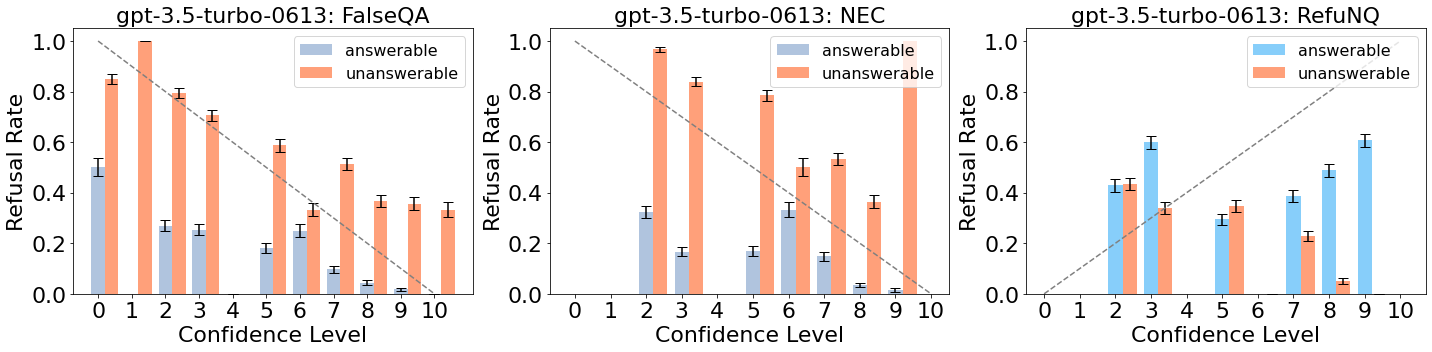

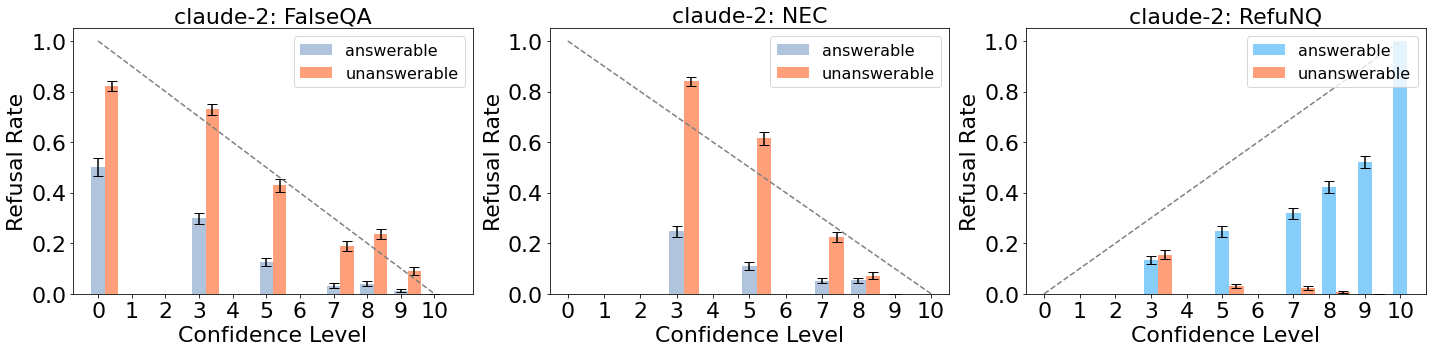

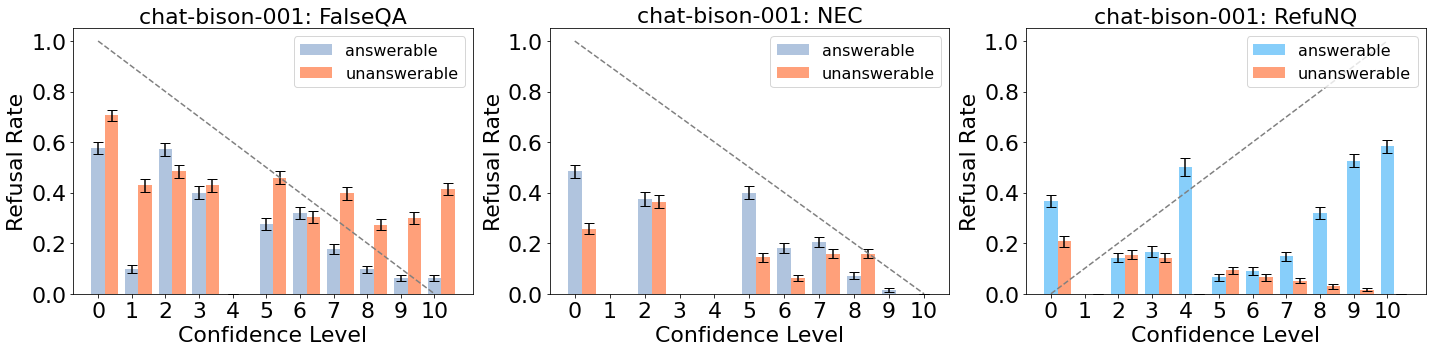

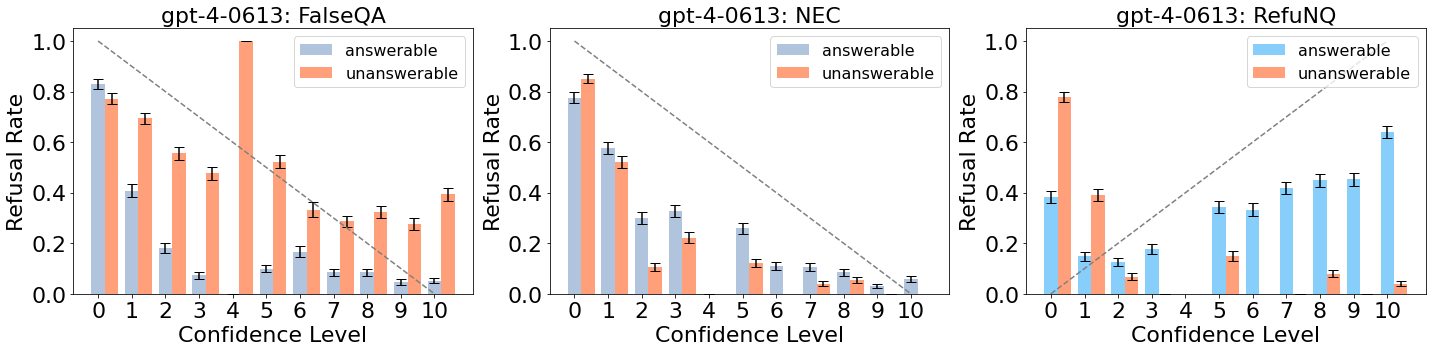

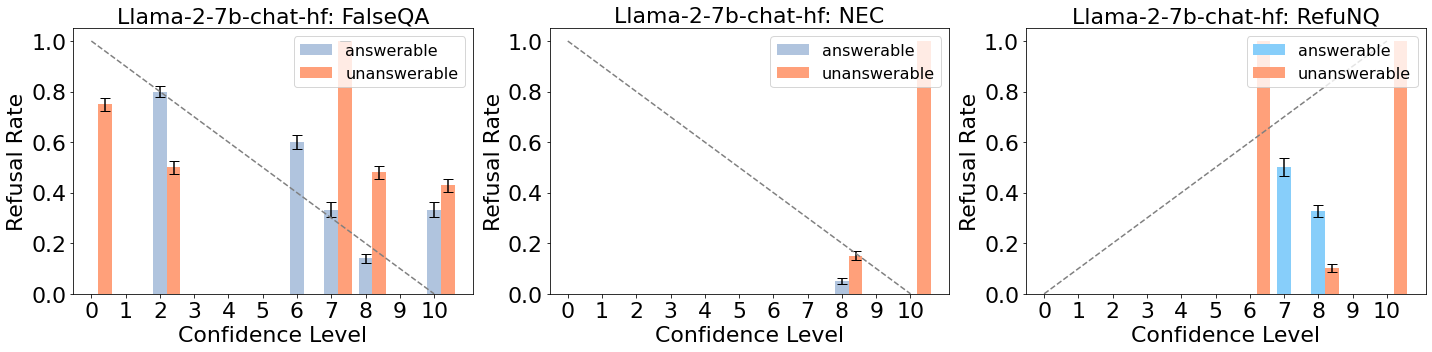

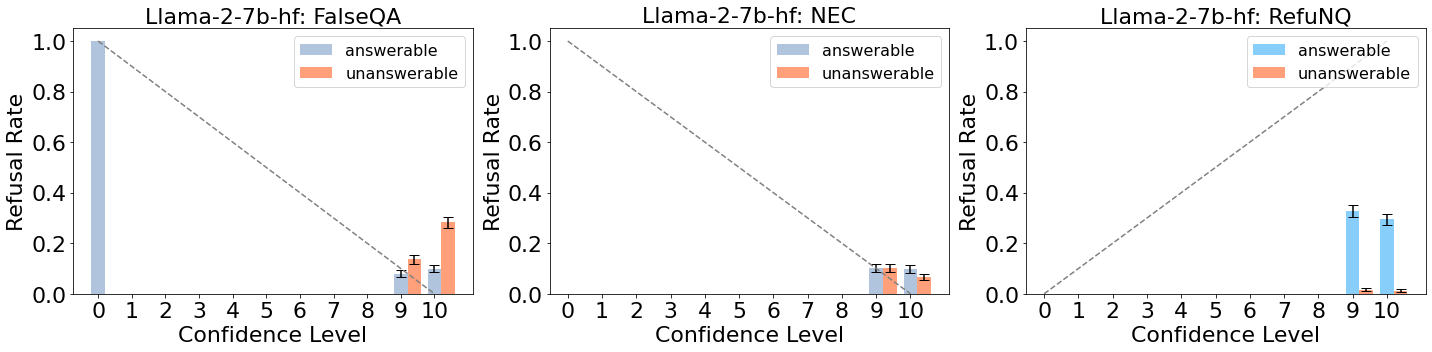

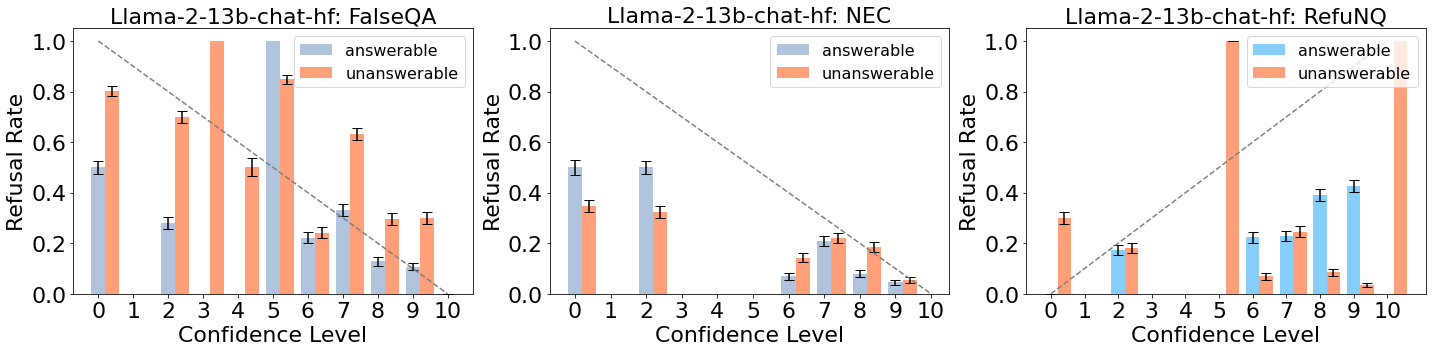

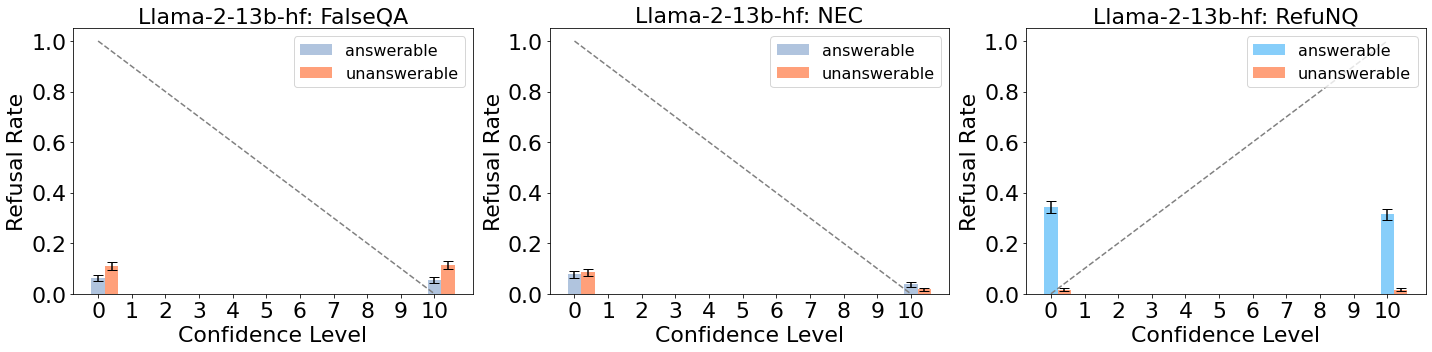

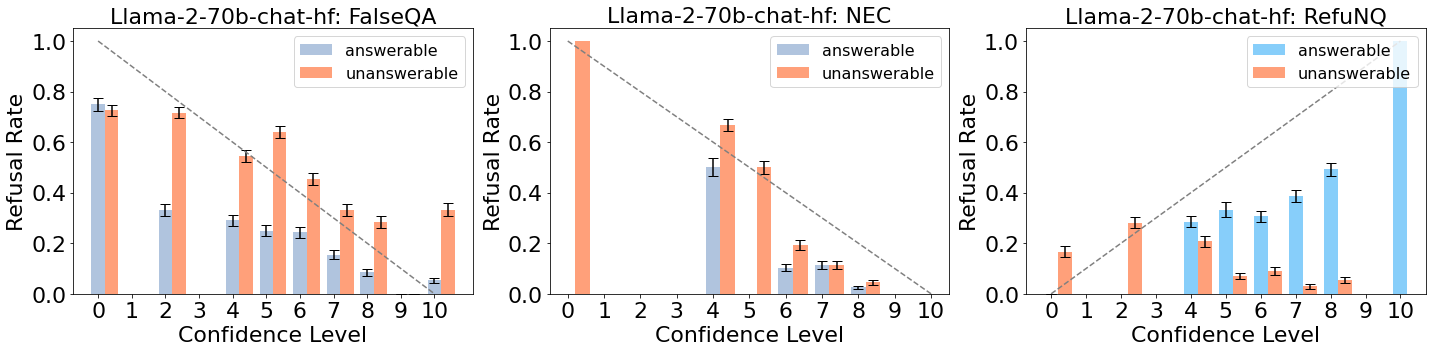

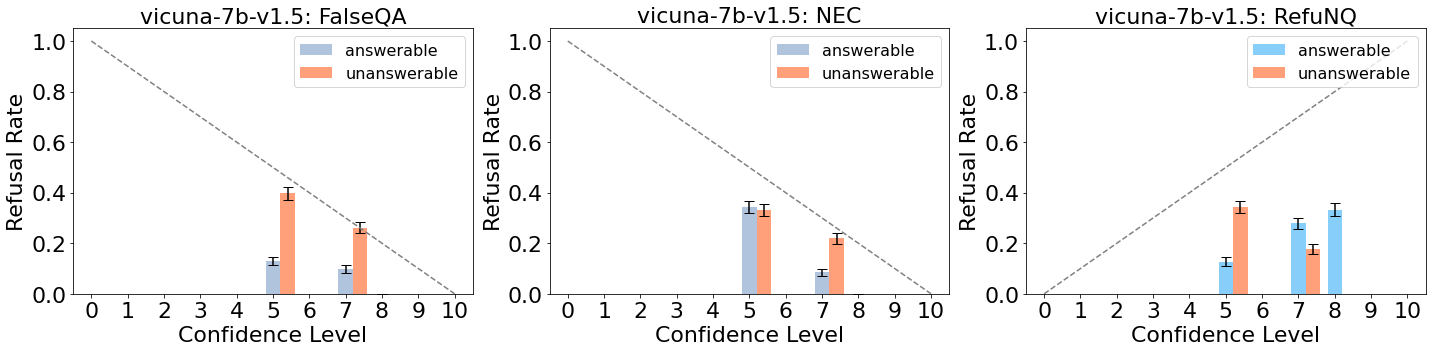

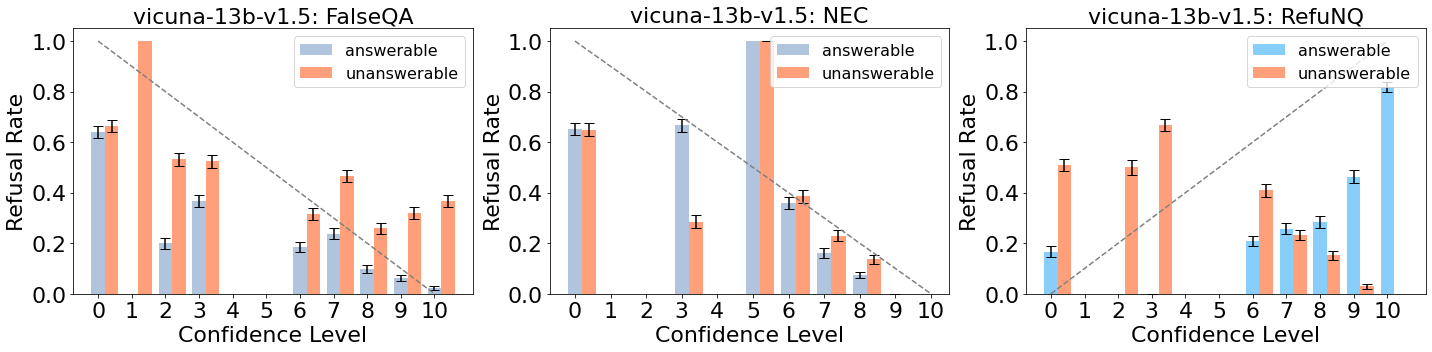

In [12]:
model_list = [
    "gpt-3.5-turbo-0613",
    "claude-2", 
    "chat-bison-001",
    "gpt-4-0613",
    
    "Llama-2-7b-chat-hf",
    "Llama-2-7b-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-13b-hf",
    "Llama-2-70b-chat-hf",
    # "Llama-2-70b-hf",
    "vicuna-7b-v1.5",
    "vicuna-13b-v1.5"
]

for model_name in model_list:
    generate_refusal_and_accuracy_plot_for_model_name(model_name)